In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Pharmaceutical stocks

### Vaxart, Inc. (Small Cap)

In [5]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/VXRT_data.csv")
print(df.head())

         Date  previous_1d      EMA_12   willr_14    OBV_7  labels
0  2000-01-21      437.250  350.035133  -6.976744  42909.0     0.0
1  2000-01-24      515.625  375.510497 -10.606061  67630.0     2.0
2  2000-01-25      424.875  383.105036 -43.939394  53407.0     2.0
3  2000-01-26      453.750  393.973492 -33.333333  57201.0     2.0
4  2000-01-27      420.750  398.092955 -50.000000  54669.0     2.0


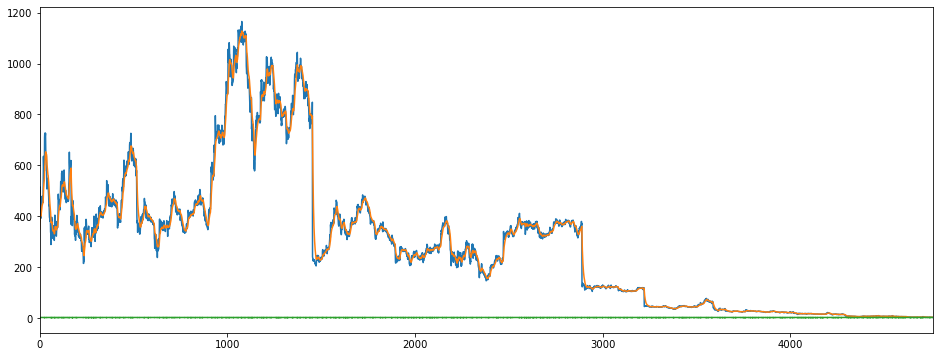

In [6]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [7]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,437.250,350.035133,-6.976744,42909.0,0.0
2000-01-24,515.625,375.510497,-10.606061,67630.0,2.0
2000-01-25,424.875,383.105036,-43.939394,53407.0,2.0
2000-01-26,453.750,393.973492,-33.333333,57201.0,2.0
2000-01-27,420.750,398.092955,-50.000000,54669.0,2.0


In [8]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [9]:
willr_data = np.array(willr_data)
willr_data.shape

(4745, 15, 1)

In [10]:
price_data = np.array(price_data)
price_data.shape

(4745, 15, 1)

In [11]:
ema_data = np.array(ema_data)
ema_data.shape

(4745, 15, 1)

In [12]:
obv_data = np.array(obv_data)
obv_data.shape

(4745, 15, 1)

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [14]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

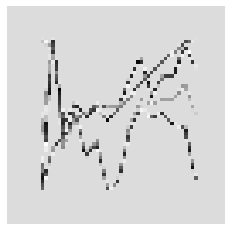

In [15]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [16]:
X = X/255

In [17]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [18]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [19]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [21]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 6.8768115942028984, 1: 7.230476190476191, 2: 0.3681505188633498}
Epoch 1/200
 1/30 [>.............................] - ETA: 0s - loss: 0.4679 - accuracy: 0.6484 - mse: 5.5827 - weighted_accuracy: 0.3897 - weighted_mse: 6.6151WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
30/30 [==============================] - 1s 26ms/step - loss: 0.2475 - accuracy: 0.3870 - mse: 1.6242 - weighted_accuracy: 0.3275 - weighted_mse: 1.7275 - val_loss: 0.1967 - val_accuracy: 0.1454 - val_mse: 0.9680 - val_weighted_accuracy: 0.1454 - val_weighted_mse: 0.9680
Epoch 2/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2062 - accuracy: 0.3617 - mse: 1.1734 - weighted_accuracy: 0.3298 - weighted_mse: 1.1948 - val_loss: 0.2091 - val_accuracy: 0.0516 - v

Epoch 27/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1959 - accuracy: 0.2339 - mse: 1.1638 - weighted_accuracy: 0.4122 - weighted_mse: 1.1492 - val_loss: 0.2035 - val_accuracy: 0.0727 - val_mse: 1.0474 - val_weighted_accuracy: 0.0727 - val_weighted_mse: 1.0474
Epoch 28/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1966 - accuracy: 0.1652 - mse: 1.2095 - weighted_accuracy: 0.4120 - weighted_mse: 1.1954 - val_loss: 0.2059 - val_accuracy: 0.0727 - val_mse: 1.0412 - val_weighted_accuracy: 0.0727 - val_weighted_mse: 1.0412
Epoch 29/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1954 - accuracy: 0.2766 - mse: 1.1835 - weighted_accuracy: 0.4046 - weighted_mse: 1.1717 - val_loss: 0.1968 - val_accuracy: 0.0790 - val_mse: 0.9347 - val_weighted_accuracy: 0.0790 - val_weighted_mse: 0.9347
Epoch 30/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1971 - accuracy: 0.2840 - mse: 1.1717 - weighted_accuracy: 0.3975 - wei

Epoch 56/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1790 - accuracy: 0.1525 - mse: 1.2641 - weighted_accuracy: 0.5126 - weighted_mse: 1.2327 - val_loss: 0.1944 - val_accuracy: 0.0738 - val_mse: 1.1176 - val_weighted_accuracy: 0.0738 - val_weighted_mse: 1.1176
Epoch 57/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1773 - accuracy: 0.1641 - mse: 1.2491 - weighted_accuracy: 0.5245 - weighted_mse: 1.1978 - val_loss: 0.1935 - val_accuracy: 0.0780 - val_mse: 1.1379 - val_weighted_accuracy: 0.0780 - val_weighted_mse: 1.1379
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1750 - accuracy: 0.1668 - mse: 1.3045 - weighted_accuracy: 0.5369 - weighted_mse: 1.2649 - val_loss: 0.1981 - val_accuracy: 0.0780 - val_mse: 1.0728 - val_weighted_accuracy: 0.0780 - val_weighted_mse: 1.0728
Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1765 - accuracy: 0.1636 - mse: 1.2752 - weighted_accuracy: 0.5281 - weig

Epoch 85/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1528 - accuracy: 0.2113 - mse: 1.4303 - weighted_accuracy: 0.6187 - weighted_mse: 1.4109 - val_loss: 0.1972 - val_accuracy: 0.1886 - val_mse: 1.2637 - val_weighted_accuracy: 0.1886 - val_weighted_mse: 1.2637
Epoch 86/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1546 - accuracy: 0.2126 - mse: 1.4637 - weighted_accuracy: 0.6072 - weighted_mse: 1.4340 - val_loss: 0.1963 - val_accuracy: 0.1802 - val_mse: 1.2684 - val_weighted_accuracy: 0.1802 - val_weighted_mse: 1.2684
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1516 - accuracy: 0.2184 - mse: 1.4533 - weighted_accuracy: 0.6334 - weighted_mse: 1.4393 - val_loss: 0.1986 - val_accuracy: 0.1602 - val_mse: 1.1899 - val_weighted_accuracy: 0.1602 - val_weighted_mse: 1.1899
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1508 - accuracy: 0.2334 - mse: 1.4584 - weighted_accuracy: 0.6356 - wei

Epoch 114/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1340 - accuracy: 0.3872 - mse: 1.6694 - weighted_accuracy: 0.7024 - weighted_mse: 1.7748 - val_loss: 0.1828 - val_accuracy: 0.4057 - val_mse: 1.4856 - val_weighted_accuracy: 0.4057 - val_weighted_mse: 1.4856
Epoch 115/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1308 - accuracy: 0.3870 - mse: 1.7171 - weighted_accuracy: 0.7116 - weighted_mse: 1.8759 - val_loss: 0.1813 - val_accuracy: 0.4215 - val_mse: 1.5552 - val_weighted_accuracy: 0.4215 - val_weighted_mse: 1.5552
Epoch 116/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1311 - accuracy: 0.3954 - mse: 1.6849 - weighted_accuracy: 0.7097 - weighted_mse: 1.8533 - val_loss: 0.1782 - val_accuracy: 0.4415 - val_mse: 1.5704 - val_weighted_accuracy: 0.4415 - val_weighted_mse: 1.5704
Epoch 117/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1300 - accuracy: 0.4062 - mse: 1.7109 - weighted_accuracy: 0.722

Epoch 143/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1141 - accuracy: 0.5306 - mse: 1.9853 - weighted_accuracy: 0.7905 - weighted_mse: 2.4462 - val_loss: 0.1568 - val_accuracy: 0.5975 - val_mse: 1.6914 - val_weighted_accuracy: 0.5975 - val_weighted_mse: 1.6914
Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1160 - accuracy: 0.5221 - mse: 2.0058 - weighted_accuracy: 0.7670 - weighted_mse: 2.4826 - val_loss: 0.1618 - val_accuracy: 0.5574 - val_mse: 1.6421 - val_weighted_accuracy: 0.5574 - val_weighted_mse: 1.6421
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1154 - accuracy: 0.5311 - mse: 1.9986 - weighted_accuracy: 0.7717 - weighted_mse: 2.4752 - val_loss: 0.1511 - val_accuracy: 0.6301 - val_mse: 1.6228 - val_weighted_accuracy: 0.6301 - val_weighted_mse: 1.6228
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1111 - accuracy: 0.5295 - mse: 2.0123 - weighted_accuracy: 0.7627 - 

Epoch 172/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1029 - accuracy: 0.6301 - mse: 2.3141 - weighted_accuracy: 0.8102 - weighted_mse: 3.1366 - val_loss: 0.1415 - val_accuracy: 0.6934 - val_mse: 1.9408 - val_weighted_accuracy: 0.6934 - val_weighted_mse: 1.9408
Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1029 - accuracy: 0.6207 - mse: 2.4188 - weighted_accuracy: 0.7982 - weighted_mse: 3.3866 - val_loss: 0.1360 - val_accuracy: 0.7197 - val_mse: 1.8374 - val_weighted_accuracy: 0.7197 - val_weighted_mse: 1.8374
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0997 - accuracy: 0.6396 - mse: 2.3891 - weighted_accuracy: 0.8189 - weighted_mse: 3.2911 - val_loss: 0.1360 - val_accuracy: 0.7302 - val_mse: 1.9545 - val_weighted_accuracy: 0.7302 - val_weighted_mse: 1.9545
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1049 - accuracy: 0.6399 - mse: 2.3903 - weighted_accuracy: 0.8036 -

In [22]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12113260477781296
Test accuracy: 0.7839831113815308


In [23]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.43482798 -2.5603344  -0.3845222 ]
 [-0.8891239  -1.8864433  -0.14620864]
 [-2.2440715  -0.7831447  -0.19303885]
 ...
 [-1.7608203  -0.8337041  -0.15099569]
 [ 0.13963075 -3.4435773  -0.7590249 ]
 [-1.7632271  -0.9991833  -0.05655429]]


Counter({2: 798, 0: 108, 1: 43})

In [24]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 859, 0: 46, 1: 44})

In [25]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 949
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 37
actual sells but predicted buy: 1
actual predicted sells: 11
actual sells but predicted hold: 34
actual holds but predicted buy: 36
actual holds but predicted sell: 96
actual predicted holds: 727
Percentage buys correct: 13.636363636363637%
Percentage sells correct: 23.91304347826087%
Percentage holds correct: 84.63329452852153%
actual buys: 44
actual sells: 46
actual holds: 859


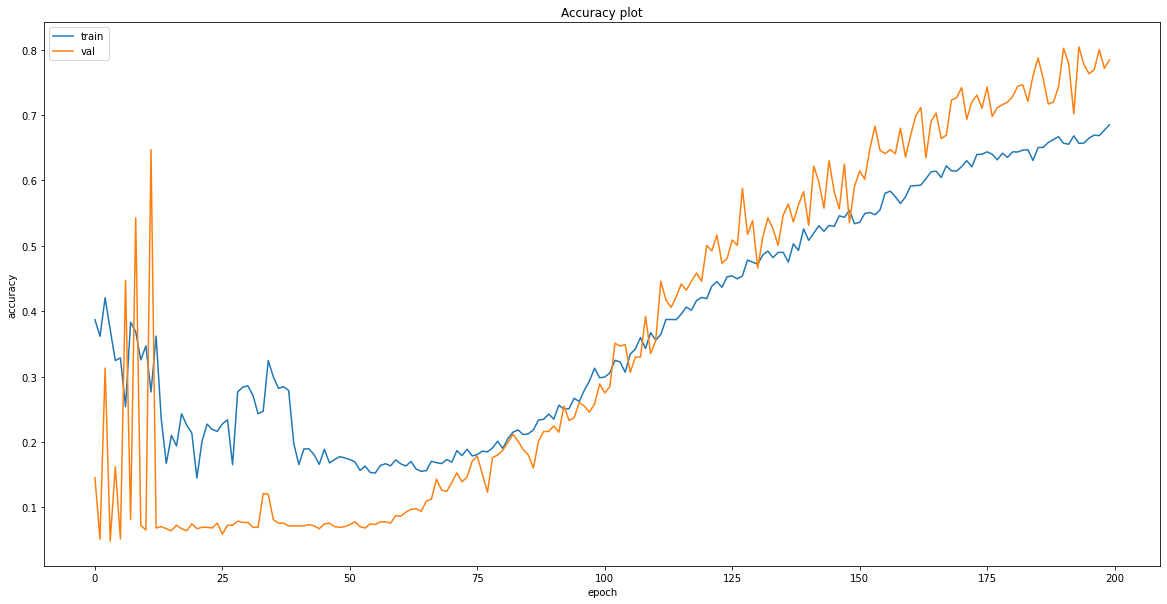

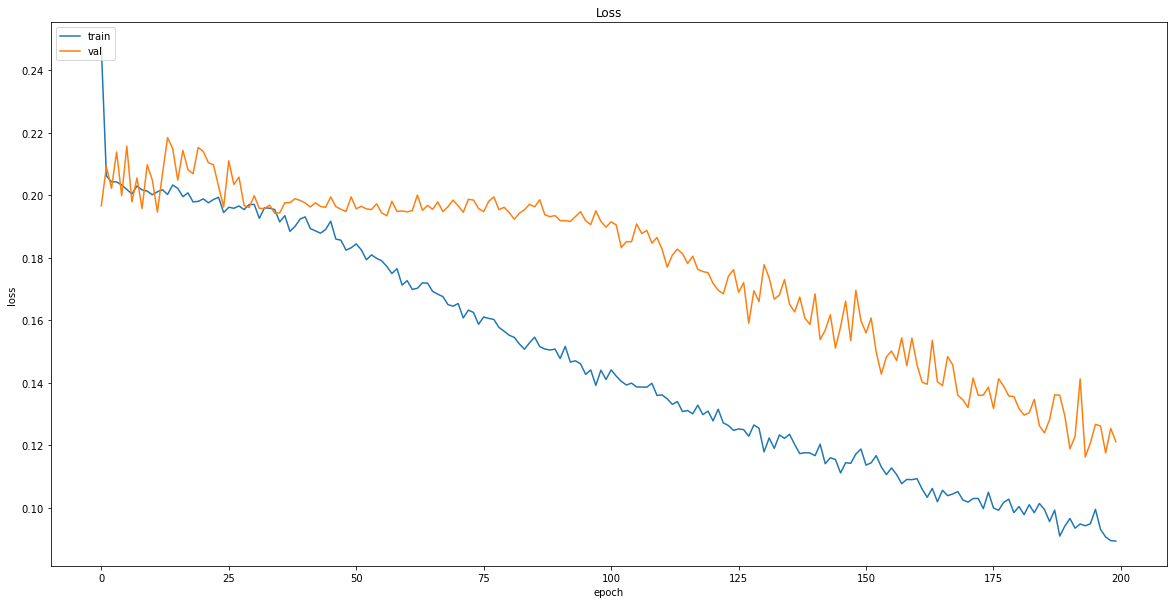

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
# Save model
model.save("models/{}".format('VXRT_image_cnn_buy_hold_sell.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/VXRT_image_cnn_buy_hold_sell.model\assets


### Inovio Pharmaceuticals, Inc. (Mid Cap)

In [28]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/INO_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14    OBV_7  labels
0  2000-01-21         51.0  54.535133 -80.952381 -17732.0     2.0
1  2000-01-24         56.0  54.760497 -57.142857 -10257.0     2.0
2  2000-01-25         58.0  55.258882 -47.619048  -8463.0     2.0
3  2000-01-26         59.0  55.834439 -42.857143  -4944.0     2.0
4  2000-01-27         57.0  56.013756 -52.380952  -5313.0     2.0


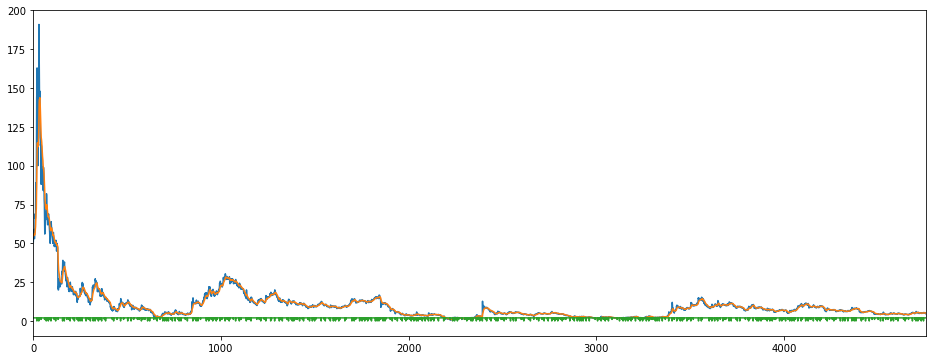

In [29]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [30]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,51.0,54.535133,-80.952381,-17732.0,2.0
2000-01-24,56.0,54.760497,-57.142857,-10257.0,2.0
2000-01-25,58.0,55.258882,-47.619048,-8463.0,2.0
2000-01-26,59.0,55.834439,-42.857143,-4944.0,2.0
2000-01-27,57.0,56.013756,-52.380952,-5313.0,2.0


In [31]:
# willr_data = []
# price_data = []
# ema_data = []
# obv_data = []
# labels = []
# data_15_price = []
# data_15_willr = []
# data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         ema_data.append(data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1

In [32]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [33]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [35]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

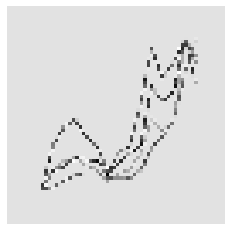

In [36]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [37]:
X = X/255

In [38]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [39]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [40]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [42]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.443137254901961, 1: 7.3140655105973025, 2: 0.3664446375132735}
Epoch 1/200
30/30 [==============================] - 1s 49ms/step - loss: 0.2446 - accuracy: 0.4307 - mse: 1.5747 - weighted_accuracy: 0.3129 - weighted_mse: 1.6345 - val_loss: 0.2095 - val_accuracy: 0.0453 - val_mse: 0.9779 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.9779
Epoch 2/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2044 - accuracy: 0.3915 - mse: 1.1749 - weighted_accuracy: 0.3243 - weighted_mse: 1.1810 - val_loss: 0.2068 - val_accuracy: 0.0917 - val_mse: 0.8334 - val_weighted_accuracy: 0.0917 - val_weighted_mse: 0.8334
Epoch 3/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2052 - accuracy: 0.3801 - mse: 1.1689 - weighted_accuracy: 0.3109 - weighted_mse: 1.1863 - val_loss: 0.2031 - val_accuracy: 0.0453 - val_mse: 1.0335 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 1.0335
Epoch 4/200
30/30 [==============================] - 0s 10ms/step - loss: 0.202

Epoch 57/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1806 - accuracy: 0.2471 - mse: 1.2392 - weighted_accuracy: 0.4913 - weighted_mse: 1.2327 - val_loss: 0.1923 - val_accuracy: 0.1960 - val_mse: 1.0351 - val_weighted_accuracy: 0.1960 - val_weighted_mse: 1.0351
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1802 - accuracy: 0.2287 - mse: 1.2304 - weighted_accuracy: 0.4788 - weighted_mse: 1.2158 - val_loss: 0.1951 - val_accuracy: 0.1644 - val_mse: 1.0424 - val_weighted_accuracy: 0.1644 - val_weighted_mse: 1.0424
Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1804 - accuracy: 0.2384 - mse: 1.2420 - weighted_accuracy: 0.4773 - weighted_mse: 1.2125 - val_loss: 0.1925 - val_accuracy: 0.1928 - val_mse: 1.0354 - val_weighted_accuracy: 0.1928 - val_weighted_mse: 1.0354
Epoch 60/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1775 - accuracy: 0.2489 - mse: 1.2713 - weighted_accuracy: 0.5067 - weig

Epoch 86/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1546 - accuracy: 0.2690 - mse: 1.4240 - weighted_accuracy: 0.6195 - weighted_mse: 1.3939 - val_loss: 0.1870 - val_accuracy: 0.2835 - val_mse: 1.2899 - val_weighted_accuracy: 0.2835 - val_weighted_mse: 1.2899
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1506 - accuracy: 0.2919 - mse: 1.4234 - weighted_accuracy: 0.6334 - weighted_mse: 1.4050 - val_loss: 0.1902 - val_accuracy: 0.2624 - val_mse: 1.2794 - val_weighted_accuracy: 0.2624 - val_weighted_mse: 1.2794
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1512 - accuracy: 0.2864 - mse: 1.4682 - weighted_accuracy: 0.6071 - weighted_mse: 1.4483 - val_loss: 0.1869 - val_accuracy: 0.2993 - val_mse: 1.3031 - val_weighted_accuracy: 0.2993 - val_weighted_mse: 1.3031
Epoch 89/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1514 - accuracy: 0.2835 - mse: 1.4244 - weighted_accuracy: 0.6301 - weig

Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1319 - accuracy: 0.4215 - mse: 1.7278 - weighted_accuracy: 0.6969 - weighted_mse: 1.8216 - val_loss: 0.1733 - val_accuracy: 0.4742 - val_mse: 1.5015 - val_weighted_accuracy: 0.4742 - val_weighted_mse: 1.5015
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1304 - accuracy: 0.4305 - mse: 1.6928 - weighted_accuracy: 0.7059 - weighted_mse: 1.8178 - val_loss: 0.1855 - val_accuracy: 0.3867 - val_mse: 1.5300 - val_weighted_accuracy: 0.3867 - val_weighted_mse: 1.5300
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1358 - accuracy: 0.4036 - mse: 1.6451 - weighted_accuracy: 0.6904 - weighted_mse: 1.7111 - val_loss: 0.1771 - val_accuracy: 0.4436 - val_mse: 1.4564 - val_weighted_accuracy: 0.4436 - val_weighted_mse: 1.4564
Epoch 118/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1318 - accuracy: 0.4252 - mse: 1.7263 - weighted_accuracy: 0.6929 - 

Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1195 - accuracy: 0.5469 - mse: 1.9642 - weighted_accuracy: 0.7429 - weighted_mse: 2.2483 - val_loss: 0.1631 - val_accuracy: 0.5743 - val_mse: 1.6950 - val_weighted_accuracy: 0.5743 - val_weighted_mse: 1.6950
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1162 - accuracy: 0.5622 - mse: 2.0101 - weighted_accuracy: 0.7449 - weighted_mse: 2.3507 - val_loss: 0.1546 - val_accuracy: 0.6322 - val_mse: 1.6684 - val_weighted_accuracy: 0.6322 - val_weighted_mse: 1.6684
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1122 - accuracy: 0.5656 - mse: 2.0298 - weighted_accuracy: 0.7608 - weighted_mse: 2.4190 - val_loss: 0.1572 - val_accuracy: 0.6101 - val_mse: 1.7138 - val_weighted_accuracy: 0.6101 - val_weighted_mse: 1.7138
Epoch 147/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1127 - accuracy: 0.5817 - mse: 2.0542 - weighted_accuracy: 0.7667 - 

Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1052 - accuracy: 0.6470 - mse: 2.3404 - weighted_accuracy: 0.7739 - weighted_mse: 2.9392 - val_loss: 0.1323 - val_accuracy: 0.7302 - val_mse: 1.8713 - val_weighted_accuracy: 0.7302 - val_weighted_mse: 1.8713
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0967 - accuracy: 0.6420 - mse: 2.4182 - weighted_accuracy: 0.7907 - weighted_mse: 3.1243 - val_loss: 0.1484 - val_accuracy: 0.6660 - val_mse: 1.9014 - val_weighted_accuracy: 0.6660 - val_weighted_mse: 1.9014
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0995 - accuracy: 0.6441 - mse: 2.4083 - weighted_accuracy: 0.7897 - weighted_mse: 3.0676 - val_loss: 0.1371 - val_accuracy: 0.7113 - val_mse: 1.8631 - val_weighted_accuracy: 0.7113 - val_weighted_mse: 1.8631
Epoch 176/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1013 - accuracy: 0.6496 - mse: 2.4131 - weighted_accuracy: 0.7861 - 

In [43]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1283499151468277
Test accuracy: 0.7397260069847107


In [44]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.6512979  -0.6695937  -0.26208743]
 [-1.0947721  -1.569874    0.12183758]
 [-2.4989338  -0.12443261 -0.6761386 ]
 ...
 [-1.5108083  -1.1629859   0.04247833]
 [-1.5573682  -0.8085848  -0.16727221]
 [-1.6271676  -1.333773    0.11290663]]


Counter({2: 761, 1: 115, 0: 73})

In [45]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 863, 0: 43, 1: 43})

In [46]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 949
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 33
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 39
actual holds but predicted buy: 106
actual holds but predicted sell: 68
actual predicted holds: 689
Percentage buys correct: 20.930232558139537%
Percentage sells correct: 9.30232558139535%
Percentage holds correct: 79.837775202781%
actual buys: 43
actual sells: 43
actual holds: 863


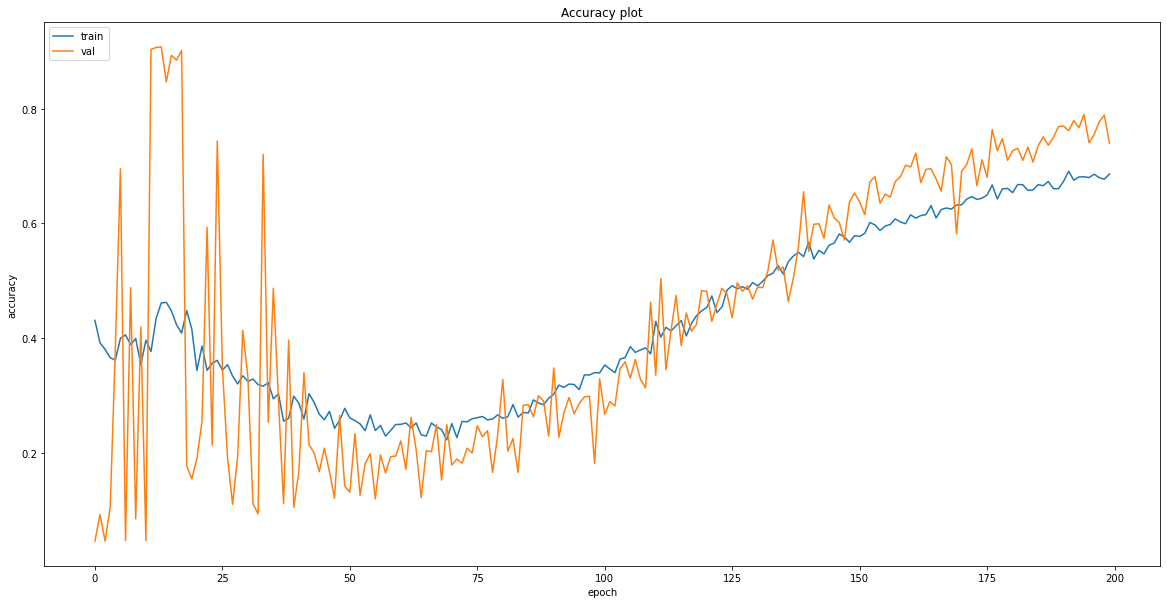

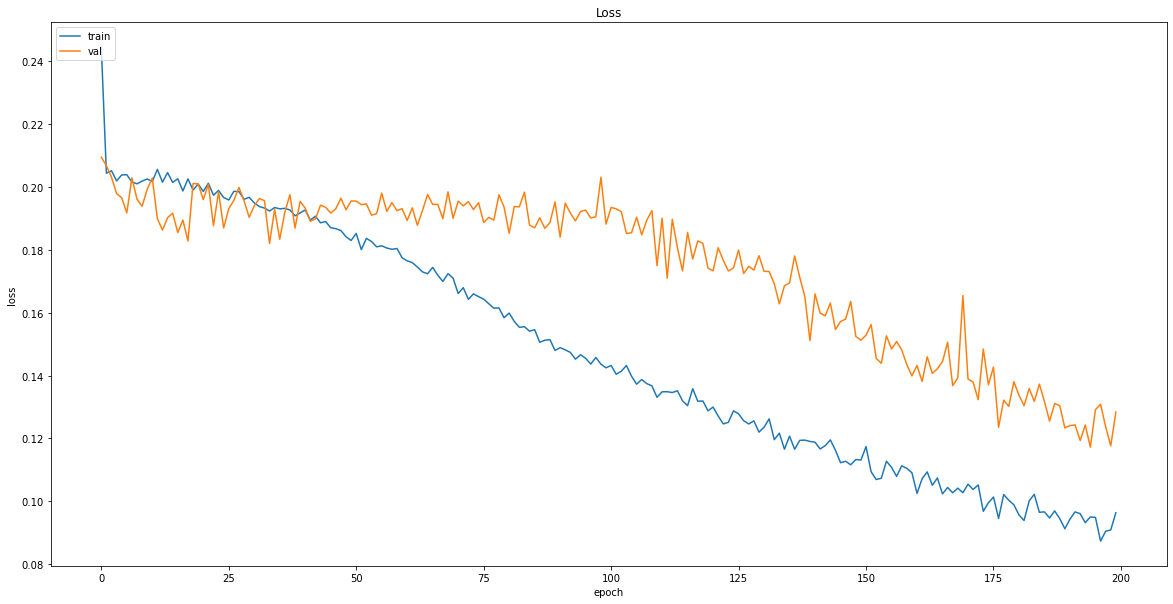

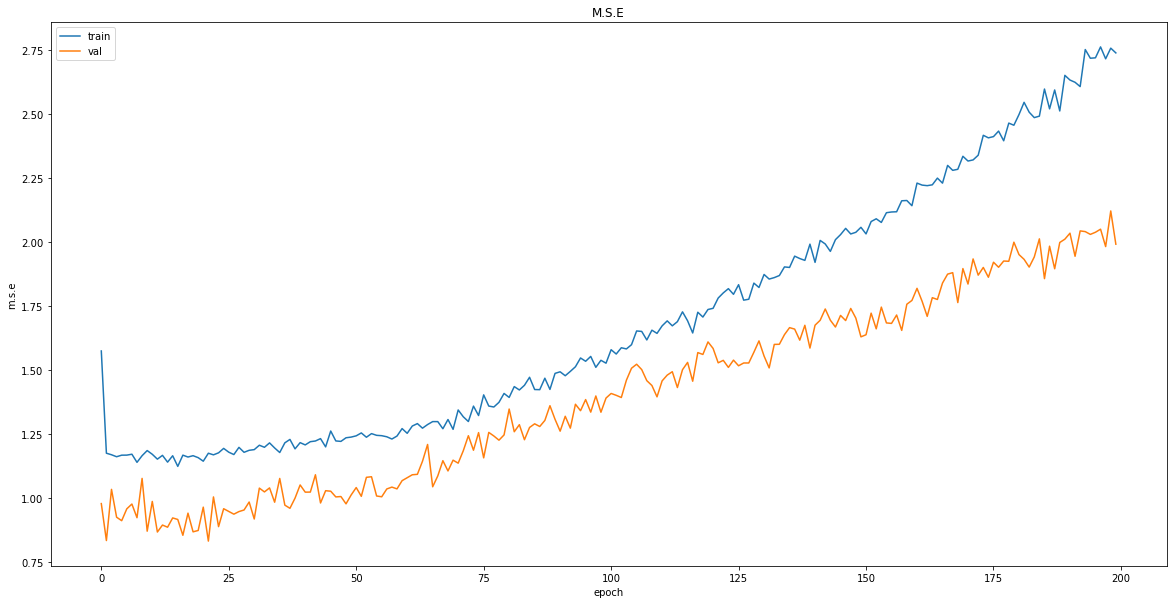

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [48]:
# Save model
model.save("models/{}".format('INO_image_cnn_buy_hold_sell.model'))

INFO:tensorflow:Assets written to: models/INO_image_cnn_buy_hold_sell.model\assets


## Novavax, Inc. (Large Cap)

In [49]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/NVAX_data.csv")
print(df.head())

         Date  previous_1d      EMA_12   willr_14    OBV_7  labels
0  2000-01-21       123.75  111.044132  -0.000000    330.0     0.0
1  2000-01-24       145.00  116.268112  -9.090909  10530.0     2.0
2  2000-01-25       130.00  118.380710 -36.363636   6930.0     2.0
3  2000-01-26       132.50  120.552908 -31.818182   9665.0     2.0
4  2000-01-27       140.00  123.544769 -18.181818  11870.0     2.0


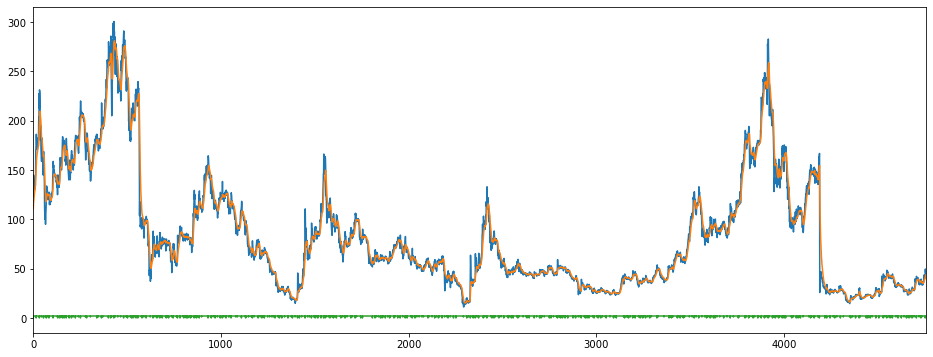

In [50]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [51]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,123.75,111.044132,-0.000000,330.0,0.0
2000-01-24,145.00,116.268112,-9.090909,10530.0,2.0
2000-01-25,130.00,118.380710,-36.363636,6930.0,2.0
2000-01-26,132.50,120.552908,-31.818182,9665.0,2.0
2000-01-27,140.00,123.544769,-18.181818,11870.0,2.0


In [52]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [53]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [55]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

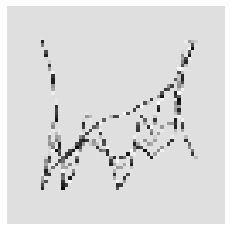

In [56]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [57]:
X = X/255

In [58]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [59]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [60]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [61]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [62]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.57684630738523, 1: 7.272030651340996, 2: 0.36623251326579837}
Epoch 1/200
30/30 [==============================] - 1s 49ms/step - loss: 0.2521 - accuracy: 0.3970 - mse: 1.5810 - weighted_accuracy: 0.3026 - weighted_mse: 1.7209 - val_loss: 0.2161 - val_accuracy: 0.0485 - val_mse: 0.9019 - val_weighted_accuracy: 0.0485 - val_weighted_mse: 0.9019
Epoch 2/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2057 - accuracy: 0.3938 - mse: 1.1614 - weighted_accuracy: 0.3601 - weighted_mse: 1.1973 - val_loss: 0.2119 - val_accuracy: 0.0432 - val_mse: 0.8710 - val_weighted_accuracy: 0.0432 - val_weighted_mse: 0.8710
Epoch 3/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2038 - accuracy: 0.3103 - mse: 1.1761 - weighted_accuracy: 0.3319 - weighted_mse: 1.1793 - val_loss: 0.2085 - val_accuracy: 0.0432 - val_mse: 0.8313 - val_weighted_accuracy: 0.0432 - val_weighted_mse: 0.8313
Epoch 4/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2040 - 

Epoch 57/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1798 - accuracy: 0.2374 - mse: 1.2710 - weighted_accuracy: 0.4939 - weighted_mse: 1.2280 - val_loss: 0.1932 - val_accuracy: 0.1507 - val_mse: 1.0490 - val_weighted_accuracy: 0.1507 - val_weighted_mse: 1.0490
Epoch 58/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1755 - accuracy: 0.2608 - mse: 1.3120 - weighted_accuracy: 0.5396 - weighted_mse: 1.2630 - val_loss: 0.1894 - val_accuracy: 0.2086 - val_mse: 1.0377 - val_weighted_accuracy: 0.2086 - val_weighted_mse: 1.0377
Epoch 59/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1780 - accuracy: 0.2352 - mse: 1.2606 - weighted_accuracy: 0.4985 - weighted_mse: 1.2280 - val_loss: 0.1914 - val_accuracy: 0.1876 - val_mse: 1.0423 - val_weighted_accuracy: 0.1876 - val_weighted_mse: 1.0423
Epoch 60/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1733 - accuracy: 0.2629 - mse: 1.3028 - weighted_accuracy: 0.5346 - we

Epoch 86/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1529 - accuracy: 0.2513 - mse: 1.5336 - weighted_accuracy: 0.6142 - weighted_mse: 1.4771 - val_loss: 0.1916 - val_accuracy: 0.2582 - val_mse: 1.3620 - val_weighted_accuracy: 0.2582 - val_weighted_mse: 1.3620
Epoch 87/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1490 - accuracy: 0.2774 - mse: 1.5271 - weighted_accuracy: 0.6578 - weighted_mse: 1.4878 - val_loss: 0.1804 - val_accuracy: 0.3519 - val_mse: 1.3325 - val_weighted_accuracy: 0.3519 - val_weighted_mse: 1.3325
Epoch 88/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1503 - accuracy: 0.2850 - mse: 1.5534 - weighted_accuracy: 0.6375 - weighted_mse: 1.5185 - val_loss: 0.1821 - val_accuracy: 0.3161 - val_mse: 1.3437 - val_weighted_accuracy: 0.3161 - val_weighted_mse: 1.3437
Epoch 89/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1507 - accuracy: 0.2482 - mse: 1.5092 - weighted_accuracy: 0.6295 - 

Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1310 - accuracy: 0.4320 - mse: 1.8301 - weighted_accuracy: 0.6980 - weighted_mse: 1.9597 - val_loss: 0.1671 - val_accuracy: 0.5111 - val_mse: 1.5341 - val_weighted_accuracy: 0.5111 - val_weighted_mse: 1.5341
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1297 - accuracy: 0.4360 - mse: 1.8060 - weighted_accuracy: 0.7128 - weighted_mse: 1.8871 - val_loss: 0.1698 - val_accuracy: 0.4963 - val_mse: 1.5296 - val_weighted_accuracy: 0.4963 - val_weighted_mse: 1.5296
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1295 - accuracy: 0.4265 - mse: 1.8328 - weighted_accuracy: 0.7090 - weighted_mse: 1.9229 - val_loss: 0.1739 - val_accuracy: 0.5026 - val_mse: 1.6378 - val_weighted_accuracy: 0.5026 - val_weighted_mse: 1.6378
Epoch 118/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1284 - accuracy: 0.4579 - mse: 1.9207 - weighted_accuracy: 0.7112 - 

Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1112 - accuracy: 0.5635 - mse: 2.0820 - weighted_accuracy: 0.7745 - weighted_mse: 2.4197 - val_loss: 0.1623 - val_accuracy: 0.5753 - val_mse: 1.8922 - val_weighted_accuracy: 0.5753 - val_weighted_mse: 1.8922
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1139 - accuracy: 0.5619 - mse: 2.2487 - weighted_accuracy: 0.7566 - weighted_mse: 2.5833 - val_loss: 0.1331 - val_accuracy: 0.7250 - val_mse: 1.8094 - val_weighted_accuracy: 0.7250 - val_weighted_mse: 1.8094
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1110 - accuracy: 0.5601 - mse: 2.2480 - weighted_accuracy: 0.7410 - weighted_mse: 2.6196 - val_loss: 0.1440 - val_accuracy: 0.6617 - val_mse: 1.7203 - val_weighted_accuracy: 0.6617 - val_weighted_mse: 1.7203
Epoch 147/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1072 - accuracy: 0.5959 - mse: 2.2973 - weighted_accuracy: 0.7842 -

Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0967 - accuracy: 0.6615 - mse: 2.6783 - weighted_accuracy: 0.7988 - weighted_mse: 3.1850 - val_loss: 0.1297 - val_accuracy: 0.7155 - val_mse: 2.1230 - val_weighted_accuracy: 0.7155 - val_weighted_mse: 2.1230
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1022 - accuracy: 0.6565 - mse: 2.6136 - weighted_accuracy: 0.7743 - weighted_mse: 3.1303 - val_loss: 0.1320 - val_accuracy: 0.7176 - val_mse: 2.1741 - val_weighted_accuracy: 0.7176 - val_weighted_mse: 2.1741
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1004 - accuracy: 0.6457 - mse: 2.6599 - weighted_accuracy: 0.7742 - weighted_mse: 3.2334 - val_loss: 0.1295 - val_accuracy: 0.7271 - val_mse: 2.1129 - val_weighted_accuracy: 0.7271 - val_weighted_mse: 2.1129
Epoch 176/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0947 - accuracy: 0.6457 - mse: 2.7039 - weighted_accuracy: 0.7932 - 

In [63]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.11454098671674728
Test accuracy: 0.7787144184112549


In [64]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.6934319  -0.67693603 -0.26658553]
 [-1.6488885  -1.6809051   0.21333493]
 [-1.0371321  -1.406704    0.0807343 ]
 ...
 [-1.0599326  -1.4114262   0.08642565]
 [-0.57465744 -1.7446699  -0.20404111]
 [-0.78803784 -2.093196   -0.00393482]]


Counter({2: 786, 0: 82, 1: 81})

In [65]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 864, 0: 41, 1: 44})

In [66]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 949
actual predicted buys: 15
actual buys but predicted sell: 0
actual buys but predicted hold: 29
actual sells but predicted buy: 2
actual predicted sells: 3
actual sells but predicted hold: 36
actual holds but predicted buy: 64
actual holds but predicted sell: 79
actual predicted holds: 721
Percentage buys correct: 34.09090909090909%
Percentage sells correct: 7.317073170731708%
Percentage holds correct: 83.44907407407408%
actual buys: 44
actual sells: 41
actual holds: 864


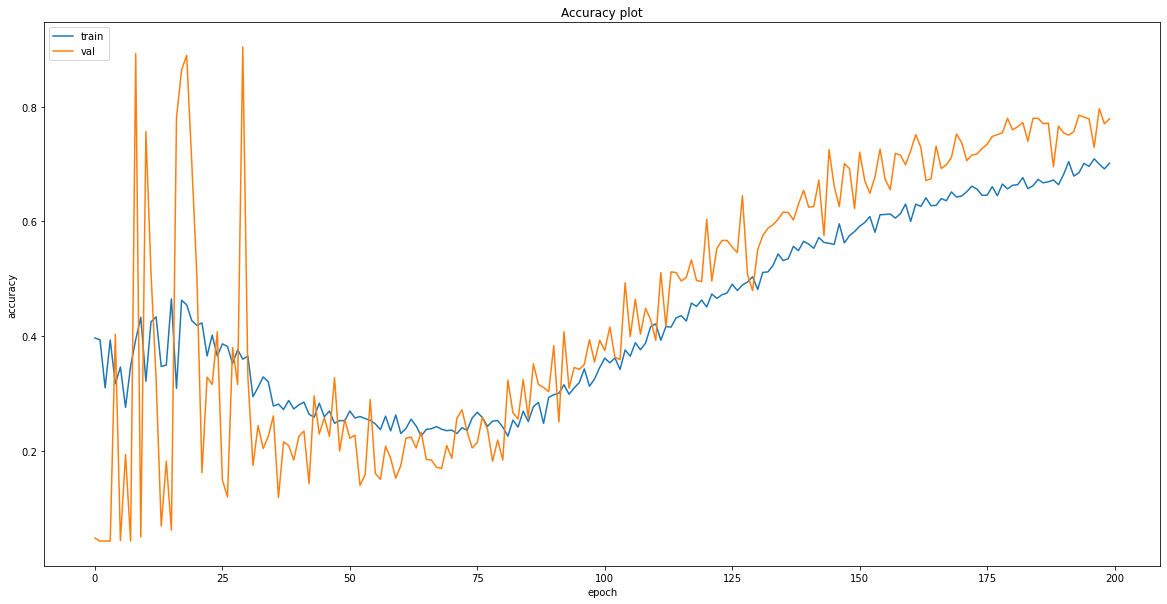

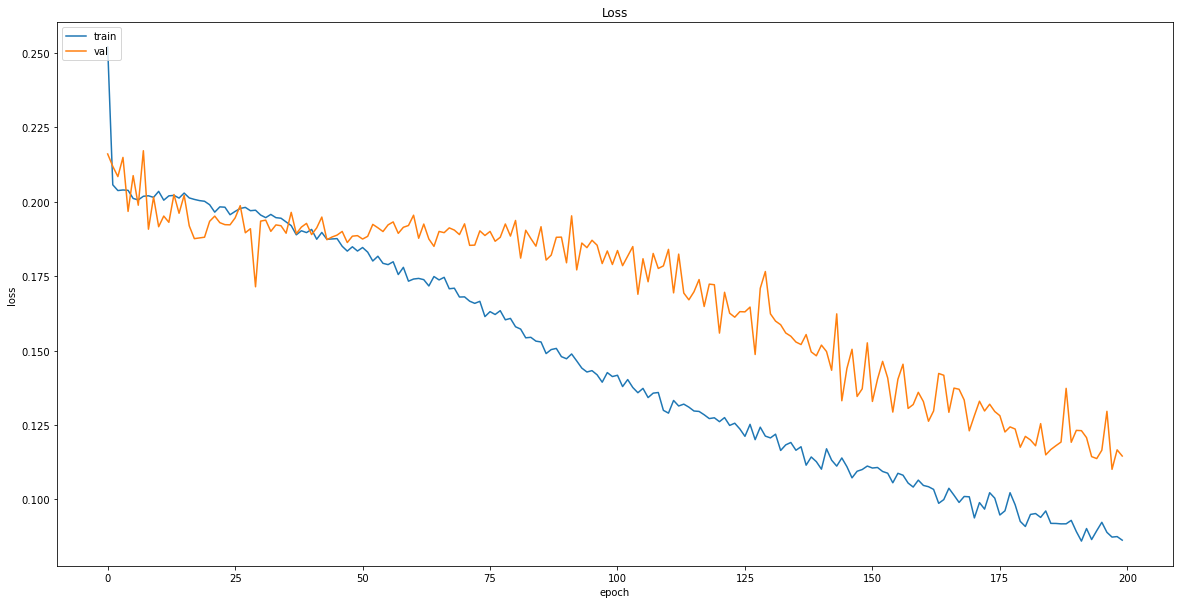

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [68]:
# Save model
model.save("models/{}".format('NVAX_image_cnn_buy_hold_sell.model'))

INFO:tensorflow:Assets written to: models/NVAX_image_cnn_buy_hold_sell.model\assets
